In [8]:
import pandas as pd
import talib 
import talib as ta
import numpy as np
from pandas_datareader.data import Options 
from binance.client import Client
from talib import MA_Type

import matplotlib.pyplot as plt

import datetime
from datetime import datetime

%matplotlib inline


#PLACE SECRETS ON .ENV
secs = open(".env", 'rb').read()
secs = dict([i.split("=") for i in secs.split("\n") if i])

PUBLIC = secs["PUBLIC"]
SECRET = secs["SECRET"]

client = Client(api_key=PUBLIC, api_secret=SECRET)




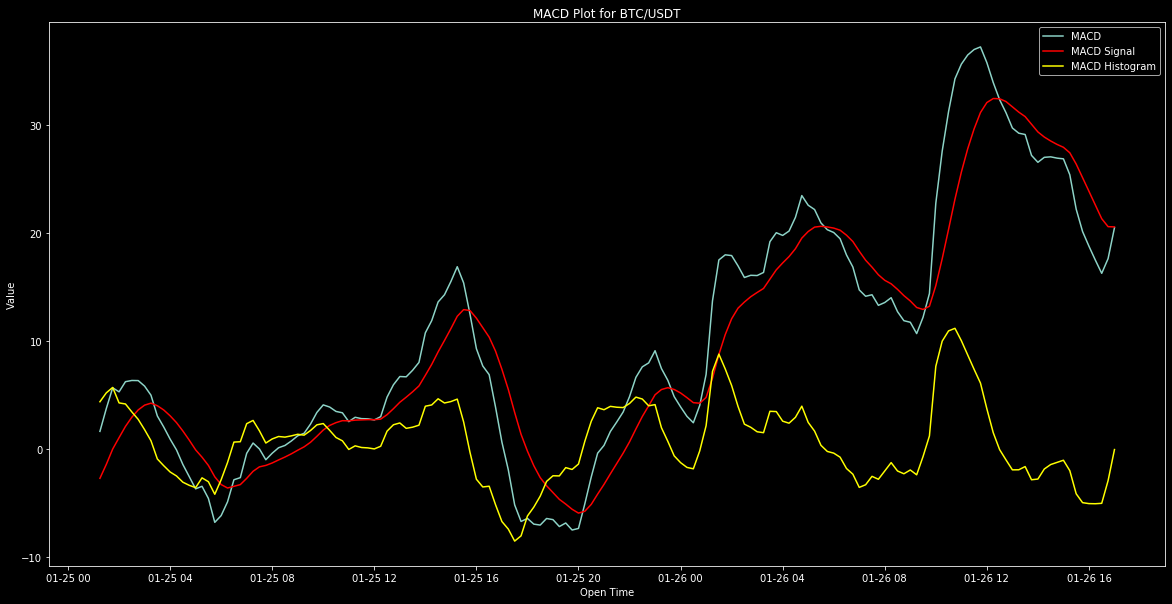

[[datetime.datetime(2020, 1, 25, 1, 15), 1.6052835619047983, 'go'], [datetime.datetime(2020, 1, 25, 3, 30), 3.0318547409351595, 'ro'], [datetime.datetime(2020, 1, 25, 6, 30), -2.878536396430718, 'go'], [datetime.datetime(2020, 1, 25, 11, 0), 2.511540376155608, 'ro'], [datetime.datetime(2020, 1, 25, 11, 15), 2.9124564956982795, 'go'], [datetime.datetime(2020, 1, 25, 12, 0), 2.668246154042208, 'ro'], [datetime.datetime(2020, 1, 25, 12, 15), 2.971322217297711, 'go'], [datetime.datetime(2020, 1, 25, 15, 45), 12.462703338962456, 'ro'], [datetime.datetime(2020, 1, 25, 20, 15), -5.096174039892503, 'go'], [datetime.datetime(2020, 1, 25, 23, 45), 4.824043902894118, 'ro'], [datetime.datetime(2020, 1, 26, 1, 0), 6.887840009239881, 'go'], [datetime.datetime(2020, 1, 26, 5, 45), 20.300306875635215, 'ro'], [datetime.datetime(2020, 1, 26, 9, 45), 14.38769723828409, 'go'], [datetime.datetime(2020, 1, 26, 12, 30), 32.35675036513567, 'ro']]


In [10]:
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_15MINUTE, "25 Jan 2020" ,"27 Jan 2020")

df = pd.DataFrame(klines, columns=["Open time", "Open", "High","Low", "Close", "Volume", "Close time", "Quote asset volume", "Number of trades", "tkb", "tkbq","ignore"])

op,clo,hi,low = df['Open'],df['Close'],df['High'],df['Low']

upper, middle, lower = talib.BBANDS(low, matype=MA_Type.T3, timeperiod=2, nbdevup=2, nbdevdn=2)

data = dict(upper=upper, middle=middle, lower=lower)
result = pd.DataFrame(data, columns=['upper', 'middle', 'lower']).dropna()
 

#result.plot(figsize=(20,10))
open_time   = [int(entry[0]) for entry in klines]
close       = [float(entry[4]) for entry in klines]
close_array = np.asarray(close)
new_time    = [datetime.fromtimestamp(time/1000) for time in open_time]

macd, macdsignal, macdhist = ta.MACD(close_array, fastperiod=12, slowperiod=26, signalperiod=9)

#plt.style.use('seaborn-white')
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.plot(new_time, macd, label='MACD')
plt.plot(new_time, macdsignal, label='MACD Signal',  color='red')
plt.plot(new_time, macdhist, label='MACD Histogram', color='yellow')
plt.title("MACD Plot for BTC/USDT")
plt.xlabel("Open Time")
plt.ylabel("Value")
plt.legend()
plt.show()




crosses = []
macdabove = False
for i in range(len(macd)):
    if np.isnan(macd[i]) or np.isnan(macdsignal[i]):
        pass
    else:
        if macd[i] > macdsignal[i]:
            if macdabove == False:
                macdabove = True
                cross = [new_time[i],macd[i],'go']
                crosses.append(cross)
        else:
            if macdabove == True:
                macdabove = False
                cross = [new_time[i],macd[i],'ro']
                crosses.append(cross)

print(crosses)

plt.style.use('dark_background')
plt.figure(figsize=(20,10))
plt.plot(new_time, macd, label='MACD', color='cyan')
plt.plot(new_time, macdsignal, label='MACD Signal', color='yellow')
for cross in crosses:
    plt.plot(cross[0],cross[1],cross[2])
#plt.plot(new_time, macdhist, label='MACD Histogram')
plt.title("MACD Plot for BTC/USDT")
plt.xlabel("Open Time")
plt.ylabel("Value")
plt.legend()
plt.show()









In [4]:
import mplfinance as mpf
import plotly.graph_objs as go


#quotes = [ list(i) for i in df[['Open', 'High', 'Low', 'Close']].values ]

ty = ['float', 'float', 'float', 'float', 'float', 'int', 'float', 'int', 'str', 'str', 'str'] 
dty = dict(zip(df.axes[1], ty))

#df = df.astype(dty) 

df['Open time'] = df['Open time'].apply( lambda x: datetime.fromtimestamp(x/1000) ) #timestamps to date %Y%M%D

df = df.set_index('Open time')

df.index.name = 'Date'


mpf.plot(df,type='candle')

data=[go.Candlestick(x=df.axes[0],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])]

go.Figure(data=data)



In [287]:
class TechProcs:

    def calc_technical_indicators(df, column_name: str, id: int, all: bool, verbose: bool):
        """
        Calculates a set of selecteed technical indicators based on the close price of the given stock
        :param df: pandas data frame
        :param column_name: MUST refer to the close price of the stock
        :return: Void - modifies the frame in place
        """
        close = np.asarray(df[column_name])
        # This is for experimenting to generate a wide range of technical indicators
        # requires subsequent feature ranking
        full_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29]
        short_range = [3, 5, 7, 10, 15, 20, 25]
        long_range = [50, 60, 70, 80, 100, 150, 200, 250]
        range = full_range + long_range

        if (id == 1 or all):
            # Bollinger bands
            df['UP_BB'], df['MID_BB'], df['LOW_BB'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
            if (verbose):
                print("ID: " + str(id))
                print("Bollinger bands")
                print(df.corr())

        if (id == 2 or all):
            # Create Simple Moving Average
            # Time range adjusted based on feature ranking for S&P500
            periods = range  # [2, 3, 4, 5, 7]
            for period in periods:
                df['SMA-' + str(period)] = talib.SMA(close, timeperiod=period)
            if (verbose):
                print("ID: " + str(id))
                print("Simple Moving Average")
                print(df.corr())

        if (id == 3 or all):
            # Create Exponential moving average
            # correlation drops at 30 and beyond
            # time range adjusted based on feature ranking for S&P500
            periods = range  # [6,7,9,12]
            for period in periods:
                df['EMA-' + str(period)] = talib.EMA(close, timeperiod=period)
            if (verbose):
                print("ID: " + str(id))
                print("Exponential Moving Average")
                print(df.corr())

        if (id == 4 or all):

            # Create Momentum
            # no strong correlation for the MOM indicators was found, thus disabled.
            # only MOM-300 yields about ~ -30% Corr.
            periods = range
            for period in periods:
                df['MOM-' + str(period)] = talib.MOM(close, timeperiod=period)
            if (verbose):
                print("ID: " + str(id))
                print("Momentum")
                print(df.corr())

        if (id == 5 or all):
            # Create RSI
            # Time range adjusted based on feature ranking for S&P500
            periods = range  # [10, 11, 12, 13, 14, 15, 21, 22]
            for period in periods:
                df['RSI-' + str(period)] = talib.RSI(close, timeperiod=period)
            if (verbose):
                print("ID: " + str(id))
                print("RSI")
                print(df.corr())

        if (id == 6 or all):
            # Create TRIX
            # Time range adjusted based on feature ranking for S&P500
            # For a smaller sample size, only Trix-30 shows higehst correlation to close price.
            # Add full range to re-test and look how Trix-30 performs
            periods = range  # [3, 4]  # range
            for period in periods:
                df['TRIX-' + str(period)] = talib.TRIX(close, timeperiod=period)

            if (verbose):
                print("ID: " + str(id))
                print("Trix")
                print(df.corr())

        if (id == 7 or all):
            # Cycle Indicator Functions
            # https://mrjbq7.github.io/ta-lib/func_groups/cycle_indicators.html
            df["HT_DCPERIOD"] = talib.HT_DCPERIOD(close)
            df["HT_DCPHASE"] = talib.HT_DCPHASE(close)
            df["HT_TRENDMODE"] = talib.HT_TRENDMODE(close)
            if (verbose):
                print("ID: " + str(id))
                print("Cycle Indicator Functions")
                print(df.corr())

    def calc_all_features(df):
        open = np.asarray(df['Open'])
        close = np.asarray(df['Close'])
        high = np.asarray(df['High'])
        low = np.asarray(df['Low'])
        volume = df['Volume']  # . For magic reasons, volume must be a pandas data frame.

        get_price_studies(open, low, high, close, df)
        get_average_studies(open, low, high, close, df)
        get_volume_studies(open, low, high, close, volume, df)
        get_momentum_studies(open, low, high, close, volume, df)
        get_cycle_studies(close, df)

    def get_price_studies(open, low, high, close, df):
        # https://mrjbq7.github.io/ta-lib/func_groups/price_transform.html
        df["AVGPRICE"] = talib.AVGPRICE(open, high, low, close)
        df["MEDPRICE"] = talib.MEDPRICE(high, low)
        df["TYPPRICE"] = talib.TYPPRICE(high, low, close)
        df["WCLPRICE"] = talib.WCLPRICE(high, low, close)
        df["ATR-5"] = talib.ATR(high, low, close, timeperiod=5)
        df["ATR-10"] = talib.ATR(high, low, close, timeperiod=10)
        df["ATR-20"] = talib.ATR(high, low, close, timeperiod=20)
        df["ATR-50"] = talib.ATR(high, low, close, timeperiod=50)
        df["ATR-200"] = talib.ATR(high, low, close, timeperiod=200)

    def get_volume_studies(open, low, high, close, volume, df):
        # Volume Indicator Functions
        # @TODO: Fix type case error of volume column
        # https://mrjbq7.github.io/ta-lib/func_groups/volume_indicators.html
        df["AD"] = talib.AD(high, low, close, volume)
        df["ADOSC"] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
        df["OBV"] = talib.OBV(close, volume)

    def get_momentum_studies(open, low, high, close, volume, df):
        # Momentum studies
        # https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
        df['MACD'], df['MACD_SIGN'], df['MACD_HIST'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        df['STOCH-SLOW-K'], df['STOCH-SLOW-D'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3,
                                                             slowk_matype=0, slowd_period=3, slowd_matype=0)
        df['STOCH-FAST-K'], df['STOCH-FAST-D'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3,
                                                              fastd_matype=0)
        df['STOCH-RSI-K'], df['STOCH-RSI-D'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3,
                                                              fastd_matype=0)
        df['AROON-DOWN'], df['AROON-UP'] = talib.AROON(high, low, timeperiod=14)
        df["MINUS_DI"] = talib.MINUS_DI(high, low, close, timeperiod=14)
        df["MINUS_DM"] = talib.MINUS_DM(high, low, timeperiod=14)
        df["PLUS_DI"] = talib.PLUS_DI(high, low, close, timeperiod=14)
        df["PLUS_DM"] = talib.PLUS_DM(high, low, timeperiod=14)
        df["MOM"] = talib.MOM(close, timeperiod=10)
        df["MFI"] = talib.MFI(high, low, close, volume, timeperiod=14)
        df["ADX"] = talib.ADX(high, low, close, timeperiod=14)
        df["ADXR"] = talib.ADXR(high, low, close, timeperiod=14)
        df["APO"] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
        df["AROONOSC"] = talib.AROONOSC(high, low, timeperiod=14)
        df["BOP"] = talib.BOP(open, high, low, close)
        df["CCI"] = talib.CCI(high, low, close, timeperiod=14)
        df["CMO"] = talib.CMO(close, timeperiod=14)
        df["DX"] = talib.DX(high, low, close, timeperiod=14)
        df["PPO"] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
        df["ROC"] = talib.ROC(close, timeperiod=10)
        df["RSI"] = talib.RSI(close, timeperiod=14)
        df["TRIX"] = talib.TRIX(close, timeperiod=30)
        df["ULT"] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
        df["WILLR"] = talib.WILLR(high, low, close, timeperiod=14)

    def get_average_studies(open, low, high, close, df):
        # https://mrjbq7.github.io/ta-lib/func_groups/overlap_studies.html
        # Bollinger bands
        df['UP_BB'], df['MID_BB'], df['LOW_BB'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
        # HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline
        df["HT"] = talib.HT_TRENDLINE(close)
        # SAR - Parabolic SAR
        df["SAR"] = talib.SAR(high, low, acceleration=0, maximum=0)
        #
        periods = [5, 15, 30, 50, 100, 200]
        for period in periods:
            df['SMA-' + str(period)] = talib.SMA(close, timeperiod=period)
            df['DEMA-' + str(period)] = talib.DEMA(close, timeperiod=period)
            df['TEMA-' + str(period)] = talib.TEMA(close, timeperiod=period)
            df['WMA-' + str(period)] = talib.WMA(close, timeperiod=period)
            df['MIDPOINT-' + str(period)] = talib.MIDPOINT(close, timeperiod=period)
            df['MIDPRICE-' + str(period)] = talib.MIDPRICE(high, low, timeperiod=period)

    def get_cycle_studies(close, df):
        # Cycle Indicator Functions
        # https://mrjbq7.github.io/ta-lib/func_groups/cycle_indicators.html
        df["HT_DCPERIOD"] = talib.HT_DCPERIOD(close)
        df["HT_DCPHASE"] = talib.HT_DCPHASE(close)
        df["HT_TRENDMODE"] = talib.HT_TRENDMODE(close)

    def get_chart_patterns(df):
        open = df['Open']
        close = df['Close']
        high = df['High']
        low = df['Low']
        # all 61 chart patterns in TA lib version 4.0.17
        # converted all int32 to bool as to conserve memory and storage
        # https://mrjbq7.github.io/ta-lib/func_groups/pattern_recognition.html
        df["CDL2CROWS"] = talib.CDL2CROWS(open, high, low, close).astype(bool)  # CDL2CROWS - Two Crows
        df["CDL3BLACKCROWS"] = talib.CDL3BLACKCROWS(open, high, low, close).astype(
            bool)  # CDL3BLACKCROWS - Three Black Crows
        df["CDL3INSIDE"] = talib.CDL3INSIDE(open, high, low, close).astype(bool)  # CDL3INSIDE - Three Inside Up/Down
        df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(open, high, low, close).astype(
            bool)  # CDL3LINESTRIKE - Three-Line Strike
        df["CDL3OUTSIDE"] = talib.CDL3OUTSIDE(open, high, low, close).astype(
            bool)  # CDL3OUTSIDE - Three Outside Up/Down
        df["CDL3STARSINSOUTH"] = talib.CDL3STARSINSOUTH(open, high, low, close).astype(
            bool)  # CDL3STARSINSOUTH - Three Stars In The South
        df["CDL3WHITESOLDIERS"] = talib.CDL3WHITESOLDIERS(open, high, low, close).astype(
            bool)  # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        df["CDLABANDONEDBABY"] = talib.CDLABANDONEDBABY(open, high, low, close, penetration=0).astype(
            bool)  # CDLABANDONEDBABY - Abandoned Baby
        df["CDLADVANCEBLOCK"] = talib.CDLADVANCEBLOCK(open, high, low, close).astype(
            bool)  # CDLADVANCEBLOCK - Advance Block
        df["CDLBELTHOLD"] = talib.CDLBELTHOLD(open, high, low, close).astype(bool)  # CDLBELTHOLD - Belt-hold
        df["CDLBREAKAWAY"] = talib.CDLBREAKAWAY(open, high, low, close).astype(bool)  # CDLBREAKAWAY - Breakaway
        df["CDLCLOSINGMARUBOZU"] = talib.CDLCLOSINGMARUBOZU(open, high, low, close).astype(
            bool)  # CDLCLOSINGMARUBOZU - Closing Marubozu
        df["CDLCONCEALBABYSWALL"] = talib.CDLCONCEALBABYSWALL(open, high, low, close).astype(
            bool)  # CDLCONCEALBABYSWALL - Concealing Baby Swallow # WTF???
        df["CDLCOUNTERATTACK"] = talib.CDLCOUNTERATTACK(open, high, low, close).astype(
            bool)  # CDLCOUNTERATTACK - Counterattack
        df["CDLDARKCLOUDCOVER"] = talib.CDLDARKCLOUDCOVER(open, high, low, close, penetration=0).astype(
            bool)  # CDLDARKCLOUDCOVER - Dark Cloud Cover
        df["CDLDOJI"] = talib.CDLDOJI(open, high, low, close).astype(bool)  # CDLDOJI - Doji
        df["CDLDOJISTAR"] = talib.CDLDOJISTAR(open, high, low, close).astype(bool)  # CDLDOJISTAR - Doji Star
        df["CDLDRAGONFLYDOJI"] = talib.CDLDRAGONFLYDOJI(open, high, low, close).astype(bool)  # Dragonfly Doji
        df["CDLENGULFING"] = talib.CDLENGULFING(open, high, low, close).astype(bool)  # Engulfing Pattern
        df["CDLEVENINGDOJISTAR"] = talib.CDLEVENINGDOJISTAR(open, high, low, close, penetration=0).astype(
            bool)  # Evening Doji Star
        df["CDLEVENINGSTAR"] = talib.CDLEVENINGSTAR(open, high, low, close, penetration=0).astype(bool)  # Evening Star
        df["CDLGAPSIDESIDEWHITE"] = talib.CDLGAPSIDESIDEWHITE(open, high, low, close).astype(
            bool)  # Up/Down-gap side-by-side white lines
        df["CDLGRAVESTONEDOJI"] = talib.CDLGRAVESTONEDOJI(open, high, low, close).astype(bool)  # Gravestone Doji
        df["CDLHAMMER "] = talib.CDLHAMMER(open, high, low, close).astype(bool)  # Hammer
        df["CDLHANGINGMAN"] = talib.CDLHANGINGMAN(open, high, low, close).astype(bool)  # Hanging Man
        df["CDLHARAMI"] = talib.CDLHARAMI(open, high, low, close).astype(bool)  # Harami Pattern
        df["CDLHARAMICROSS"] = talib.CDLHARAMICROSS(open, high, low, close).astype(bool)  # Harami Cross Pattern
        df["CDLHIGHWAVE"] = talib.CDLHIGHWAVE(open, high, low, close).astype(bool)  # High-Wave Candle
        df["CDLHIKKAKE"] = talib.CDLHIKKAKE(open, high, low, close).astype(bool)  # Hikkake Pattern
        df["CDLHIKKAKEMOD"] = talib.CDLHIKKAKEMOD(open, high, low, close).astype(bool)  # Modified Hikkake Pattern
        df["CDLHOMINGPIGEON"] = talib.CDLHOMINGPIGEON(open, high, low, close).astype(bool)  # Homing Pigeon
        df["CDLIDENTICAL3CROWS"] = talib.CDLIDENTICAL3CROWS(open, high, low, close).astype(
            bool)  # Identical Three Crows
        df["CDLINNECK"] = talib.CDLINNECK(open, high, low, close).astype(bool)  # In-Neck Pattern
        df["CDLINVERTEDHAMMER"] = talib.CDLINVERTEDHAMMER(open, high, low, close).astype(bool)  # Inverted Hammer
        df["CDLKICKING"] = talib.CDLKICKING(open, high, low, close).astype(bool)  # Kicking
        df["CDLKICKINGBYLENGTH"] = talib.CDLKICKINGBYLENGTH(open, high, low, close).astype(
            bool)  # Kicking - bull/bear determined by the longer marubozu
        df["CDLLADDERBOTTOM"] = talib.CDLLADDERBOTTOM(open, high, low, close).astype(bool)  # Ladder Bottom
        df["CDLLONGLEGGEDDOJI"] = talib.CDLLONGLEGGEDDOJI(open, high, low, close).astype(bool)  # Long Legged Doji
        df["CDLLONGLINE"] = talib.CDLLONGLINE(open, high, low, close).astype(bool)  # Long Line Candle
        df["CDLMARUBOZU"] = talib.CDLMARUBOZU(open, high, low, close).astype(bool)  # Marubozu
        df["CDLMATCHINGLOW"] = talib.CDLMATCHINGLOW(open, high, low, close).astype(bool)  # Matching Low
        df["CDLMATHOLD"] = talib.CDLMATHOLD(open, high, low, close, penetration=0).astype(bool)  # Mat Hold
        df["CDLMORNINGDOJISTAR"] = talib.CDLMORNINGDOJISTAR(open, high, low, close, penetration=0).astype(
            bool)  # Morning Doji Star
        df["CDLMORNINGSTAR"] = talib.CDLMORNINGSTAR(open, high, low, close, penetration=0).astype(bool)  # Morning Star
        df["CDLONNECK"] = talib.CDLONNECK(open, high, low, close).astype(bool)  # On-Neck Pattern
        df["CDLPIERCING"] = talib.CDLPIERCING(open, high, low, close).astype(bool)  # Piercing Pattern
        df["CDLRICKSHAWMAN"] = talib.CDLRICKSHAWMAN(open, high, low, close).astype(bool)  # Rickshaw Man
        df["CDLRISEFALL3METHODS"] = talib.CDLRISEFALL3METHODS(open, high, low, close).astype(
            bool)  # Rising/Falling Three Methods
        df["CDLSEPARATINGLINES"] = talib.CDLSEPARATINGLINES(open, high, low, close).astype(bool)  # Separating Lines
        df["CDLSHOOTINGSTAR"] = talib.CDLSHOOTINGSTAR(open, high, low, close).astype(bool)  # Shooting Star
        df["CDLSHORTLINE"] = talib.CDLSHORTLINE(open, high, low, close).astype(bool)  # Short Line Candle
        df["CDLSPINNINGTOP"] = talib.CDLSPINNINGTOP(open, high, low, close).astype(bool)  # Spinning Top
        df["CDLSTALLEDPATTERN"] = talib.CDLSTALLEDPATTERN(open, high, low, close).astype(bool)  # Stalled Pattern
        df["CDLSTICKSANDWICH"] = talib.CDLSTICKSANDWICH(open, high, low, close).astype(bool)  # Stick Sandwich
        df["CDLTAKURI"] = talib.CDLTAKURI(open, high, low, close).astype(
            bool)  # Takuri (Dragonfly Doji with very long lower shadow)
        df["CDLTASUKIGAP"] = talib.CDLTASUKIGAP(open, high, low, close).astype(bool)  # Tasuki Gap
        df["CDLTHRUSTING"] = talib.CDLTHRUSTING(open, high, low, close).astype(bool)  # Thrusting Pattern
        df["CDLTRISTAR"] = talib.CDLTRISTAR(open, high, low, close).astype(bool)  # Tristar Pattern
        df["CDLUNIQUE3RIVER"] = talib.CDLUNIQUE3RIVER(open, high, low, close).astype(bool)  # Unique 3 River
        df["CDLUPSIDEGAP2CROWS"] = talib.CDLUPSIDEGAP2CROWS(open, high, low, close).astype(bool)  # Upside Gap Two Crows
        df["CDLXSIDEGAP3METHODS "] = talib.CDLXSIDEGAP3METHODS(open, high, low, close).astype(
            bool)  # Upside/Downside Gap Three Methods

        

In [294]:
t = TechProcs
t.get_chart_patterns(df)

df.tail(2)

Open           High            Low  \
Date                                                               
2020-01-16 16:00:00  8720.34000000  8748.00000000  8712.39000000   
2020-01-16 17:00:00  8720.15000000  8743.99000000  8672.44000000   

                             Close         Volume     Close time  \
Date                                                               
2020-01-16 16:00:00  8720.01000000   860.06047000  1579219199999   
2020-01-16 17:00:00  8690.31000000  1988.85257700  1579222799999   

                    Quote asset volume  Number of trades           tkb  \
Date                                                                     
2020-01-16 16:00:00   7508152.33312964             13491  451.81672300   
2020-01-16 17:00:00  17306551.07986089             19321  649.50749400   

                                 tkbq  ... CDLSPINNINGTOP  CDLSTALLEDPATTERN  \
Date                                   ...                                     
2020-01-16 16:00:00  3944514.40566311  ...           True              False   
2020-01-16 17:00:00  5654001.32589583  ...          False              False   

                     CDLSTICKSANDWICH  CDLTAKURI  CDLTASUKIGAP  CDLTHRUSTING  \
Date                                                                           
2020-01-16 16:00:00             False      False         False         False   
2020-01-16 17:00:00             False      False         False         False   

                     CDLTRISTAR  CDLUNIQUE3RIVER  CDLUPSIDEGAP2CROWS  \
Date                                                                   
2020-01-16 16:00:00       False            False               False   
2020-01-16 17:00:00       False            False               False   

                     CDLXSIDEGAP3METHODS   
Date                                       
2020-01-16 16:00:00                 False  
2020-01-16 17:00:00                 False  

[2 rows x 72 columns]